In [1]:
import json
import os
import sys

sys.path.append('../')
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.fft import fft2, fftshift, ifft2, ifftshift

from models.ADMM import ADMM
from models.ResUNet import ResUNet
from models.Unrolled_ADMM import Unrolled_ADMM
from models.WienerNet import Wiener, WienerNet
from utils.simulations import PSF, get_delays, wavefront_real
from utils.utils_torch import get_fourier_coord

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data_path = '/mnt/WD6TB/tianaoli/dataset/Mice_new/'
idx = 143

# obss, psfs = [], []
# for i in range(13):
#     for j in range(13):
#         psf = torch.load(os.path.join(data_path, 'psf', f"psf_{idx*169+i*13+j}.pth"))
#         psfs.append(psf)
#         obs = torch.from_numpy(np.load(os.path.join(data_path, 'obs', f"obs_{idx*169+13*i+j}.npy"))).float()
#         obss.append(obs)

IP_img = np.load(os.path.join(data_path, 'full_image', 'IP', f'IP_{idx}.npy')) 
IP_img = IP_img/np.abs(IP_img).mean()
obs_full = np.load(os.path.join(data_path, 'full_image', 'obs', f"fullimg_{idx}.npy")) 
obs_full = obs_full/np.abs(obs_full).mean()

In [3]:
info_file = os.path.join(data_path, 'info.json')
with open(info_file, 'r') as f:
    info = json.load(f)
    print(' Successfully loaded dataset information from %s.', info_file)
    
params = info['params']
R = params[idx]['R'] 
v0 = params[idx]['v0']
v1 = params[idx]['v1']
l = 3.2e-3
print(R, v0, v1)

 Successfully loaded dataset information from %s. /mnt/WD6TB/tianaoli/dataset/Mice_new/info.json
0.01053834856511215 1504.861566850284 1649.3416306317245


In [4]:
delays = get_delays(R, v0, v1, 8, 'linear')

obss, psfs = [], []
for i in range(13):
    for j in range(13):
        x, y = (j-6)*l / 2, (6-i)*l / 2
        r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
        w_real = wavefront_real(R, torch.tensor(r), torch.tensor(phi), v0, v1)
        k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
        psf = []
        for id, delay in enumerate(delays):
            psf.append(PSF(theta2D, k2D, w_real, delay))
        psf = torch.stack(psf, dim=0)
        psfs.append(psf)
        
        obss.append(obs_full[:,40*i:40*i+80, 40*j:40*j+80])

### Small Patch

In [5]:
i, j = 2, 6
x, y = (j-6)*l / 2, (6-i)*l / 2
r = np.sqrt(x**2 + y**2)
C0 = (1-v0/v1) * R * (1 - (r**2)/(4*R**2))
print('r={:.2f}mm   C0={:.2f}mm'.format(r*1e3, C0*1e3))
gt = IP_img[40*i:40*i+80, 40*j:40*j+80]
gt /= np.abs(gt.mean())
# plt.imshow(gt, cmap='gray')

r=6.40mm   C0=0.84mm


In [6]:
model = Wiener()
# model = ADMM(n_iters=30)
model.to(device)
model.eval()

Wiener()

In [7]:
obs, psf = torch.Tensor(obss[i*13+j]), psfs[i*13+j]
obs, psf = obs.unsqueeze(0).to(device), psf.to(device)
mean = obs.abs().mean()
with torch.no_grad():
    rec = model(obs/mean, psf, 0.1) * mean
obs = obs.squeeze(0).detach().cpu().numpy()
rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
rec /= np.abs(rec).mean()

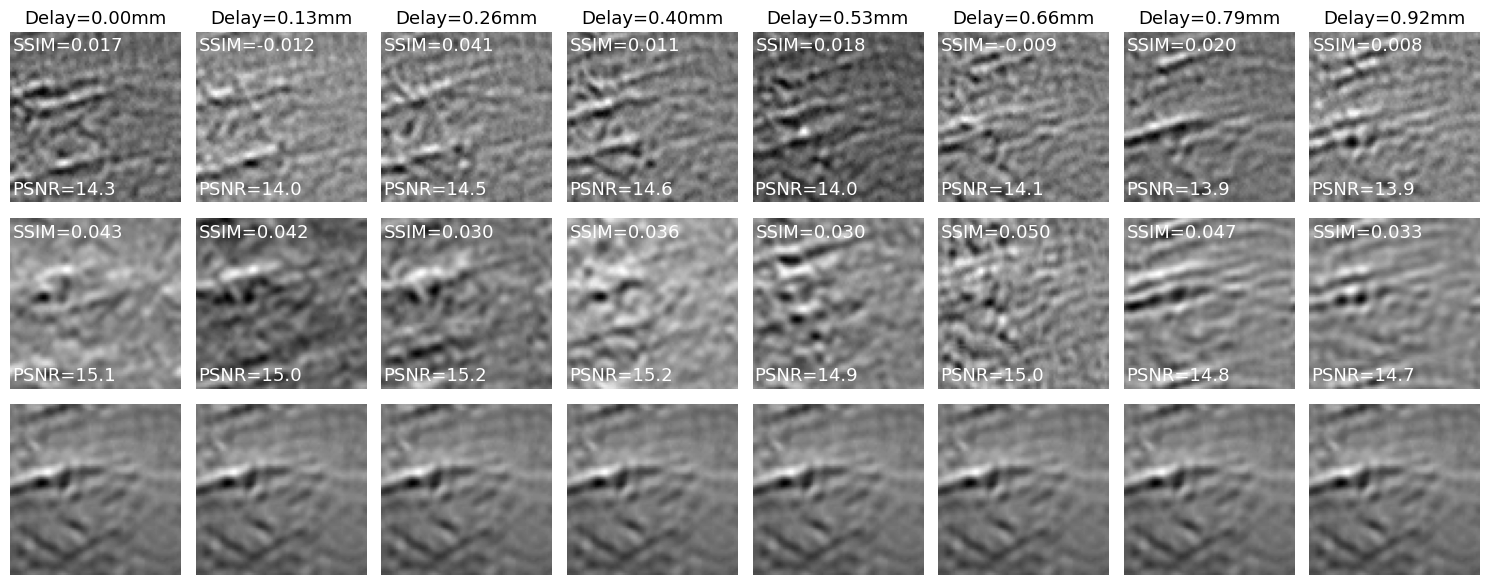

In [8]:
plt.figure(figsize=(15,6))
for i in range(8):
    plt.subplot(3,8,i+1)
    plt.imshow(obs[i], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(delays[i]*1e3), fontsize=13)
    plt.title("SSIM={:.3f}".format(ssim(obs[i], gt, data_range=30)), x=0.017, y=0.84, loc='left', fontsize=13, color='white')
    plt.title("PSNR={:.1f}".format(psnr(obs[i], gt, data_range=30)), x=0.62, y=0.0, loc='right', fontsize=13, color='white')
    plt.axis('off')
    
    plt.subplot(3,8,i+9)
    plt.imshow(rec[i], cmap='gray')
    plt.title("SSIM={:.3f}".format(ssim(rec[i], gt, data_range=30)), x=0.017, y=0.84, loc='left', fontsize=13, color='white')
    plt.title("PSNR={:.1f}".format(psnr(rec[i], gt, data_range=30)), x=0.62, y=0.0, loc='right', fontsize=13, color='white')
    plt.axis('off')
    
    plt.subplot(3,8,i+17)
    plt.imshow(gt, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [9]:
assert False

AssertionError: 

### Wiener Deconvolution

In [ ]:
def gaussian_kernel(sigma, size):
    function = lambda x,y: np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2) / (2*(sigma**2)))
    kernel = np.fromfunction(function, (size, size), dtype=float)
    return kernel / np.sum(kernel)

fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = gaussian_kernel(sigma, 80)

In [ ]:
rec_full, weights = np.zeros_like(IP_img), np.zeros_like(IP_img)
for i in range(13):
    for j in range(13):
        obs, psf = torch.Tensor(obss[i*13+j]), psfs[i*13+j]
        obs, psf = obs.unsqueeze(0).to(device), psf.to(device)
        mean = obs.abs().mean()
        with torch.no_grad():
            rec = model(obs/mean, psf, 0.1) * mean
        rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
        rec_full[40*i:40*i+80, 40*j:40*j+80] += rec.mean(axis=0).squeeze() * gaussian_window
        weights[40*i:40*i+80, 40*j:40*j+80] += 1
rec_full = rec_full/weights
rec_fulls = rec_full/np.abs(rec_full).mean()

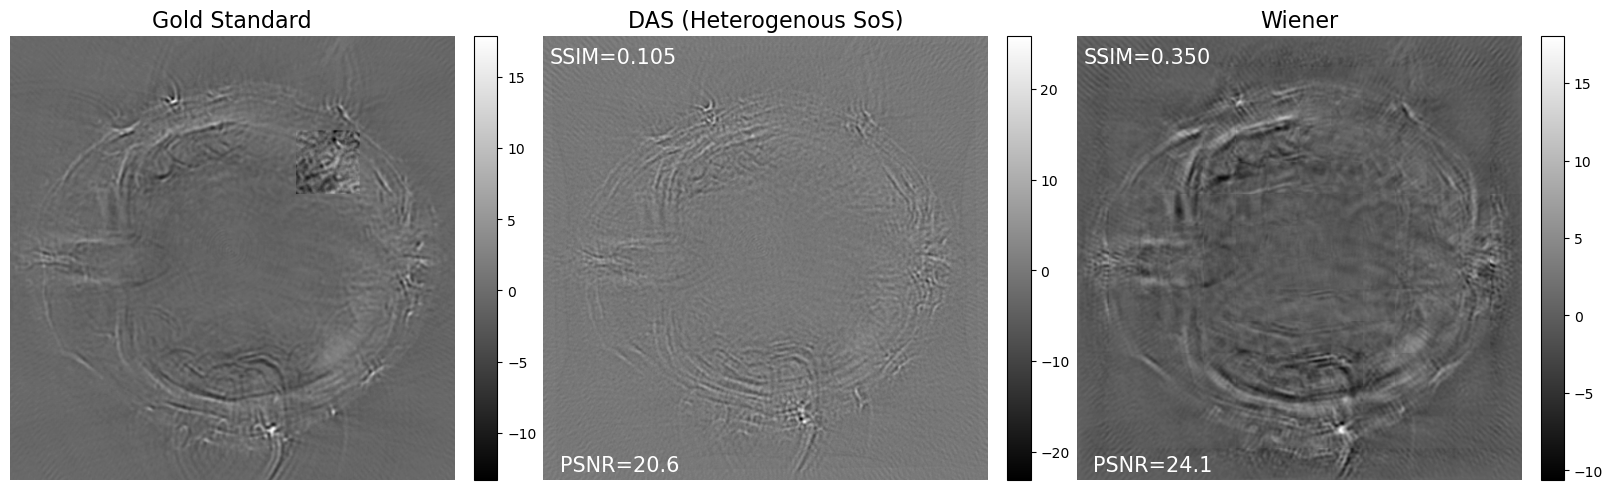

In [ ]:
fig = plt.figure(figsize=(19.5, 8))
ax1 = plt.subplot(1,3,1)
plt.imshow(IP_img, cmap='gray')
plt.title('Gold Standard', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.012, ax1.get_position().height])
cb = plt.colorbar(cax=cax)

ax3 = plt.subplot(1,3,2)
plt.imshow(obs_full[4], cmap='gray')
plt.title('DAS (Heterogenous SoS)', fontsize=16)
plt.title("SSIM={:.3f}".format(ssim(obs_full[3], IP_img, data_range=20)), x=0.015, y=0.92, loc='left', fontsize=15, color='white')
plt.title("PSNR={:.1f}".format(psnr(obs_full[3], IP_img, data_range=20)), x=0.306, y=0.0, loc='right', fontsize=15, color='white')
plt.axis('off')
cax = fig.add_axes([ax3.get_position().x1+0.01, ax3.get_position().y0, 0.012, ax3.get_position().height])
cb = plt.colorbar(cax=cax)

ax4 = plt.subplot(1,3,3)
plt.imshow(rec_fulls, cmap='gray')
plt.title(f'Wiener', fontsize=16)
plt.title("SSIM={:.3f}".format(ssim(rec_fulls, IP_img, data_range=20)), x=0.015, y=0.92, loc='left', fontsize=15, color='white')
plt.title("PSNR={:.1f}".format(psnr(rec_fulls, IP_img, data_range=20)), x=0.306, y=0.0, loc='right', fontsize=15, color='white')
plt.axis('off')
cax = fig.add_axes([ax4.get_position().x1+0.01, ax4.get_position().y0, 0.012, ax4.get_position().height])
cb = plt.colorbar(cax=cax)